Clasificador de digitos. Modelo de Deep Learning creado en Pytorch.

In [28]:
#Importar librerias
import torch
from torchvision import datasets #Descargar el dateset
from torchvision.transforms import ToTensor #Convertir los datos en tensores
import matplotlib.pyplot as plt #Graficar imagenes y categorias
from torchvision import transforms #Transfer Learning
from torch.optim import lr_scheduler
import torch.optim as optim

#Crear directorio de datos
train = datasets.MNIST(
    root = 'datos', #Carpeta donde se almacenara
    train = True, #True + 60.000 imagenes, False + 10.000 imagenes
    download = True,
    transform = ToTensor() #Convertir imagenes a tensores.
)

test = datasets.MNIST(
    root = 'datos', #Carpeta donde se almacenara
    train = True, #True + 60.000 imagenes, False + 10.000 imagenes
    download = True,
    transform = ToTensor() #Convertir imagenes a tensores.
)


#Detectar la GPU
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Usando {device}")

Usando cuda


Crear modelo de red nueronal.

In [29]:
#Importat red neural
from torch import nn

#Crear red neuronal
class RedNeuronal(nn.Module):
  def __init__(self):
    super().__init__()

    #Agregar las capas:
    self.aplanar = nn.Flatten() #Aplanar las imagenes de entrtada
    self.red = nn.Sequential(
          nn.Linear(28*28, 15), #Capa de entrada y capa oculta
          nn.ReLU(), # Activacion de capa oculta
          nn.Linear(15, 10) #Capa de salida sin activacion
        )
  def forward(self, x): #Definir operaciones a aplicar
    x = self.aplanar(x) #Aplanar dato
    logits = self.red(x) #Generar prediccion

    return logits

modelo = RedNeuronal().to(device) #Enviar red nueronal a GPU


Entrenamiento.

In [30]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1000 #DEFINIR TAMANO DEL LOTE

train_dataloader = DataLoader( #Crear los dataloaders para los sets de entrenamiento y validacion.
    dataset = train,
    batch_size = BATCH_SIZE,
    shuffle = True # Mezclar los datos aleatoriamente al crear cada lote
)

val_dataloader = DataLoader( #
    dataset = test,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [31]:
#Hiperparametros
TAZA_APRENDIZAJE = 0.10 #Learning rate (0.1)
EPOCHS = 10 #Numero de iteraciones de entrenamiento

#Funcion de poerdida y optimizador
fn_perdida = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr = TAZA_APRENDIZAJE)

In [32]:
def train_loop(dataloader, model, loss_fn, optimizer): #Cantidad de datos de entrenamiento y cantidad de lotes
  train_size = len(dataloader.dataset)
  nlotes = len(dataloader)

  model.to(device)
  model.train() #Indicar que se va a entrenar el modelo.

  perdida_train, exactitud = 0,0 #Inicializar indicadores de perdida y exactitud

  #Presentar los datos al modelo por lotes
  for lote_i, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device) #mover X y Y a la GPU

    #Forward Propagation
    logits = model(X)

    #Back Propagation
    loss = loss_fn(logits, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    perdida_train += loss.item()
    exactitud += (logits.argmax(1)==y).type(torch.float).sum().item()

    #Imprimir en pantalla la evoluvion del entrenamiento
    if lote_i % 10 == 0 :
      ndatos = lote_i * BATCH_SIZE # batch_size
      print(f"\tPérdida: {loss.item():>7f}  [{ndatos:>5d}/{train_size:>5d}]")

  # Al terminar de presentar todos los datos al modelo, promediar pérdida y exactitud
  perdida_train /= lote_i # Pérdida promedio = pérdida acumulada / número de lotes
  exactitud /= train_size # Exactitud promedio = exactitud acumulada / número de datos

  #Imprimir información
  print(f'\tExactitud/pérdida promedio:')
  print(f'\t\tEntrenamiento: {(100*exactitud):>0.1f}% / {perdida_train:>8f}')


Validacion:

In [33]:
def val_loop(dataloader, model, loss_fn):
  val_size = len(dataloader.dataset) #Cantidad de datos de validacion
  nlotes = len(dataloader) #Cantidad de lotes

  model.eval() #Indicar validacion el modelo

  perdida_val, exactitud = 0, 0 #Inicializar acumuladores de perdida y exactitud

  with torch.no_grad():
    for X, y in dataloader: #Evaluar. geneara las predicciones usando no_grad
        X, y = X.to(device), y.to(device) #Mover x y Y a la GPU

        logits = model(X) #Propagacion hacia delante

        # Acumular valores de pérdida y exactitud
        perdida_val += loss_fn(logits, y).item()
        exactitud += (logits.argmax(1) == y).type(torch.float).sum().item()

  #Calcular promedio de perdida y exactitud
  perdida_val /= nlotes
  exactitud /= val_size

  #Imprimir resultados:
  print(f"\t\tValidación: {(100*exactitud):>0.1f}% / {perdida_val:>8f} \n")


Efecutar entrenamiento y validacion:

In [34]:
for i in range(EPOCHS):
  print(f"Iteración {i+1}/{EPOCHS}\n-------------------------------")
  #Entrenar
  train_loop(train_dataloader, modelo, fn_perdida, optimizador)
  #Validar
  val_loop(val_dataloader, modelo, fn_perdida)

print("Listo. El modelo ha sido entrenado.")

Iteración 1/10
-------------------------------
	Pérdida: 2.296918  [    0/60000]
	Pérdida: 2.071507  [10000/60000]
	Pérdida: 1.762930  [20000/60000]
	Pérdida: 1.475424  [30000/60000]
	Pérdida: 1.203884  [40000/60000]
	Pérdida: 1.008914  [50000/60000]
	Exactitud/pérdida promedio:
		Entrenamiento: 65.0% / 1.546833
		Validación: 80.5% / 0.866595 

Iteración 2/10
-------------------------------
	Pérdida: 0.856549  [    0/60000]
	Pérdida: 0.798475  [10000/60000]
	Pérdida: 0.673054  [20000/60000]
	Pérdida: 0.649749  [30000/60000]
	Pérdida: 0.643292  [40000/60000]
	Pérdida: 0.563959  [50000/60000]
	Exactitud/pérdida promedio:
		Entrenamiento: 83.7% / 0.686289
		Validación: 86.0% / 0.552621 

Iteración 3/10
-------------------------------
	Pérdida: 0.535098  [    0/60000]
	Pérdida: 0.545842  [10000/60000]
	Pérdida: 0.496553  [20000/60000]
	Pérdida: 0.524649  [30000/60000]
	Pérdida: 0.428278  [40000/60000]
	Pérdida: 0.415847  [50000/60000]
	Exactitud/pérdida promedio:
		Entrenamiento: 86.9% / 0

Probar con imagen aleatoria:

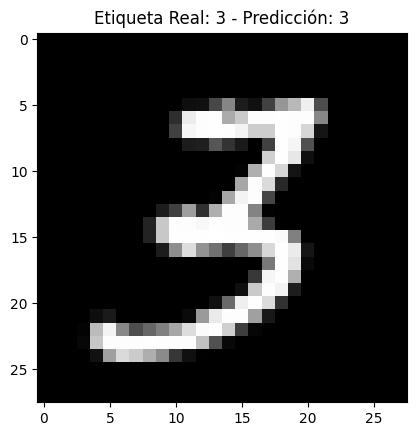

In [35]:
#Prueba con una imagen

import random

# Seleccionar una imagen aleatoria del conjunto de prueba
indice = random.randint(0, len(test) - 1)
image, label = test[indice]
image = image.unsqueeze(0).to(device) # Añadir dimensión de lote y mover a GPU

# Hacer una predicción
modelo.eval()
with torch.no_grad():
	logits = modelo(image)
	prediction = logits.argmax(1).item()

# Mostrar la imagen y la predicción
plt.imshow(image.cpu().squeeze(), cmap='gray')
plt.title(f"Etiqueta Real: {label} - Predicción: {prediction}")
plt.show()

Transfer Learning:

In [36]:
import torchvision.models as models
from torch import nn
import torch.optim as optim

# Cargar un modelo preentrenado
modelo = models.resnet50(pretrained=True)

# Congelar las capas del modelo
for param in modelo.parameters():
    param.requires_grad = False

# Redefinir la capa final para que se ajuste a tu tarea específica (10 clases en este caso)
num_ftes = modelo.fc.in_features
modelo.fc = nn.Linear(num_ftes, 10)

# Enviar el modelo a la GPU
modelo = modelo.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelo.fc.parameters(), lr=0.001)

# Función de entrenamiento
def train_model(modelo, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        modelo.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

    return modelo

# Entrenar el modelo
modelo = train_model(modelo, criterion, optimizer)


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1000, 1, 28, 28] to have 3 channels, but got 1 channels instead